# Cross Entropy Method

In [1]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

In [2]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [3]:
import warnings
warnings.simplefilter('ignore', UserWarning)

In [4]:
plt.style.use('ggplot')

## Set Configs

In [5]:
is_cuda = torch.cuda.is_available()

if is_cuda: device = torch.device('cuda')
else: device = torch.device('cpu')

In [6]:
GAMMA = 1.0
PRINT_EVERY = 10
POP_SIZE = 50
ELITE_FRAC = 0.2
SIGMA = 0.5

## Set Environment

In [7]:
ENV_NAME = 'MountainCarContinuous-v0'
env = gym.make(ENV_NAME).unwrapped; env.seed(90);

In [8]:
print('Environment Display:')
env.reset() # reset environment to a new, random state
env.render()

print('State space {}'.format(env.observation_space))
print('Action space {}'.format(env.action_space))

Environment Display:
State space Box(2,)
Action space Box(1,)


## Define The Policy

In [9]:
class Policy(nn.Module):
    """Define non-linear Policy."""
    
    def __init__(self, env, hidden_size=16):
        
        super(Policy, self).__init__()
        
        self.env = env
        state_size = env.observation_space.shape[0]
        action_size = env.action_space.shape[0]
        
        self.state_size = state_size
        self.action_size = action_size
        self.hidden_size = hidden_size
        
        # define layers
        self.fc1_layer = nn.Linear(self.state_size, self.hidden_size)
        self.fc2_layer = nn.Linear(self.hidden_size, self.action_size)
        
    def set_weights(self, weights):
        
        state_size = self.state_size
        action_size = self.action_size
        hidden_size = self.hidden_size
        
        # separate the weights for each layer
        fc1_end = (state_size*hidden_size) + hidden_size
        fc1_W = torch.from_numpy(weights[:state_size*hidden_size].reshape(state_size, hidden_size))
        fc1_b = torch.from_numpy(weights[state_size*hidden_size:fc1_end])
        
        fc2_W = torch.from_numpy(weights[fc1_end:fc1_end+(hidden_size*action_size)].reshape(hidden_size, action_size))
        fc2_b = torch.from_numpy(weights[fc1_end+(hidden_size*action_size):])
        
        # set the weights for each layer
        self.fc1_layer.weight.data.copy_(fc1_W.view_as(self.fc1_layer.weight.data))
        self.fc1_layer.bias.data.copy_(fc1_b.view_as(self.fc1_layer.bias.data))
        
        self.fc2_layer.weight.data.copy_(fc2_W.view_as(self.fc2_layer.weight.data))
        self.fc2_layer.bias.data.copy_(fc2_b.view_as(self.fc2_layer.bias.data))
        
    def get_dim_weights(self):
        
        dim_weights = (self.state_size+1) * self.hidden_size + (self.hidden_size+1) * self.action_size
        return dim_weights
    
    def evaluate(self, weights, gamma=1.0, max_time=5000):
        
        self.set_weights(weights)
        episode_return = 0.0
        
        state = self.env.reset()
        
        for time in range(max_time):
            
            state = torch.from_numpy(state).float().to(device)
            action = self.forward(state).cpu().data
            
            next_state, reward, done, _ = self.env.step(action)
            episode_return += reward * math.pow(gamma, time)
            
            state = next_state
            if done:
                break
                
        return episode_return
        
    def forward(self, x):
        
        x = F.relu(self.fc1_layer(x))
        x = F.tanh(self.fc2_layer(x))
        
        return x

In [10]:
policy = Policy(env).to(device)

## Train The Agent

In [11]:
def train_agent(num_episodes=500, max_time=1000, gamma=1.0, pop_size=50, elite_frac=0.2, sigma=0.5):
    """Train agent using cross entropy algorithm."""
    
    num_elite = int(pop_size*elite_frac)
    
    scores = []
    scores_window = deque(maxlen=100)
    
    best_weights = sigma * np.random.randn(policy.get_dim_weights())
    
    for i_episode in range(1, num_episodes+1):
        
        pop_weights = [best_weights + (sigma*np.random.randn(policy.get_dim_weights())) for _ in range(pop_size)]
        rewards = np.array([policy.evaluate(weights, gamma, max_time) for weights in pop_weights])
        
        elite_indices = rewards.argsort()[-num_elite:]
        elite_weights = [pop_weights[i] for i in elite_indices]
        best_weights = np.array(elite_weights).mean(axis=0)
        
        reward = policy.evaluate(best_weights, gamma=1.0)
        scores_window.append(reward)
        scores.append(reward)
        
        print(f'\rEpisode: {i_episode}, Average Score: {np.mean(scores_window):.2f}', end='')
        
        if i_episode % PRINT_EVERY == 0:
            print(f'\rEpisode: {i_episode}, Average Score: {np.mean(scores_window):.2f}')
        if np.mean(scores_window)>=90.0:
            print(f'\nEnvironment solved in {i_episode-100:d} episodes! Average Score: {np.mean(scores_window):.2f}')
            break
            
    if not os.path.exists('./agents/'): os.makedirs('./agents/')
    torch.save(policy.state_dict(), f'./agents/CE_{ENV_NAME}.pth')
    print('Training completed.')
    
    return scores

In [12]:
scores = train_agent(num_episodes=500, max_time=1000)

Episode: 10, Average Score: -23.42
Episode: 20, Average Score: -25.78
Episode: 30, Average Score: -26.64
Episode: 40, Average Score: -19.03
Episode: 50, Average Score: -14.51
Episode: 60, Average Score: 2.8697
Episode: 70, Average Score: 15.59
Episode: 80, Average Score: 25.35
Episode: 90, Average Score: 32.99
Episode: 100, Average Score: 39.16
Episode: 110, Average Score: 50.91
Episode: 120, Average Score: 63.09
Episode: 130, Average Score: 75.26
Episode: 140, Average Score: 83.98
Episode: 145, Average Score: 90.04
Environment solved in 45 episodes! Average Score: 90.04
Training completed.


## Evaluate The Agent

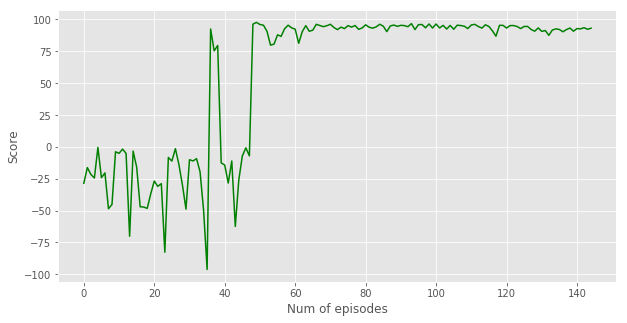

In [13]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(scores)), scores, color='green')
plt.xlabel('Num of episodes')
plt.ylabel('Score')
if not os.path.exists('./images/'): os.makedirs('./images/')
plt.savefig('./images/plot_of_cross_entropy_policy_evaluation.png')
plt.show()

## 🎬 Watch The Smart Agent

In [14]:
# load the weights of smart agent
policy.load_state_dict(torch.load(f'./agents/CE_{ENV_NAME}.pth'));

In [15]:
num_episodes = 5

for i_episode in range(1, num_episodes+1):
    
    state = env.reset()
    rewards = []
    for time_step in range(1000):
        
        env.render() # render the screen
        
        state = torch.from_numpy(state).float().to(device)
        action = policy.forward(state).cpu().data # select an action
        next_state, reward, done, _ = env.step(action)
        
        state = next_state
        rewards.append(reward)
        if done:
            break
            
    print(f'\rEpisode: {i_episode}, Average Score: {sum(rewards):.2f}')

env.close()

Episode: 1, Average Score: 93.26
Episode: 2, Average Score: 93.02
Episode: 3, Average Score: 90.94
Episode: 4, Average Score: 93.02
Episode: 5, Average Score: 93.03


---